In [7]:
import json
import argparse

# 命令行参数解析
parser = argparse.ArgumentParser()
parser.add_argument('--train_xj', type=str, default=None, help='训练轴承列表, 逗号分隔')
parser.add_argument('--test_xj', type=str, default=None, help='测试轴承列表, 逗号分隔')
parser.add_argument('--context_xj', type=str, default=None, help='上下文轴承列表, 逗号分隔')
parser.add_argument('--validation_xj', type=str, default=None, help='验证轴承列表, 逗号分隔')
args, unknown = parser.parse_known_args()

with open('../../config/bilstm_config.json', 'r') as f:
    config = json.load(f)

# 解析命令行参数，优先级高于config
if args.train_xj is not None:
    TRAIN_xj = [x.strip() for x in args.train_xj.split(',') if x.strip()]
else:
    TRAIN_xj = config['train_bearings']
if args.test_xj is not None:
    TEST_xj = [x.strip() for x in args.test_xj.split(',') if x.strip()]
else:
    TEST_xj = config['test_bearings']
if args.context_xj is not None:
    CONTEXT_xj = [x.strip() for x in args.context_xj.split(',') if x.strip()]
else:
    CONTEXT_xj = config['context_bearings']
if args.validation_xj is not None:
    VALIDATION_xj = [x.strip() for x in args.validation_xj.split(',') if x.strip()]
else:
    VALIDATION_xj = config['validation_bearings']

batch_size = config['batch_size']
test_batch_size = config['test_batch_size']
window_size = config['window_size']
input_dim = config['input_dim']
output_dim = config['output_dim']
hidden_layer_sizes = config['hidden_layer_sizes']
kernel_size = config['kernel_size']
dropout = config['dropout']
epochs = config['epochs']
learn_rate = config['learn_rate']
seed = config['seed']
patience = config['patience']
opt = config['opt']

if patience == "inf":
    patience = epochs
else:
    patience = int(patience)


# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
import os
torch.autograd.set_detect_anomaly(True)
# 参数与配置
torch.manual_seed(seed)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前运行设备: {device}")
from torch.optim.lr_scheduler import CosineAnnealingLR
FPT_dict_xj = {'Bearing1_1': 76, 'Bearing1_2': 44, 'Bearing1_3': 60, 'Bearing1_4': 0, 'Bearing1_5': 39,
            'Bearing2_1': 455, 'Bearing2_2': 48, 'Bearing2_3': 327, 'Bearing2_4': 32, 'Bearing2_5': 141,
            'Bearing3_1': 2344, 'Bearing3_2': 0, 'Bearing3_3': 340, 'Bearing3_4': 1418, 'Bearing3_5': 9}
# 加载数据集
def dataloader(batch_size, test_batch_size, workers=os.cpu_count(), window_size=7):
    # 根据TRAIN_xj，TEST_xj从datasetresult/xjtu_made目录下加载相应训练集和测试集的数据和标签
    def get_data_and_labels(bearing_list, data_dir='../../datasetresult/xjtu_made', window_size=window_size, is_test=False):
        data_list = []
        label_list = []
        for bearing in bearing_list:
            # 文件名格式: c*_Bearing*_*_data, c*_Bearing*_*_label
            # 只要包含该bearing名即可
            data_files = [f for f in os.listdir(data_dir) if bearing in f and f.endswith('_fpt_data')]
            label_files = [f for f in os.listdir(data_dir) if bearing in f and f.endswith('_fpt_label')]
            # 按文件名排序，确保一一对应
            data_files.sort()
            label_files.sort()
            for data_file, label_file in zip(data_files, label_files):
                data = load(os.path.join(data_dir, data_file))
                data_len_origin = len(data)
                label = load(os.path.join(data_dir, label_file))
                # 如果是测试集，且FPT_dict_xj中有该bearing，截取FPT值往后的数据，并重新打标签
                # if is_test and bearing in FPT_dict_xj:
                #     fpt = FPT_dict_xj[bearing]
                #     # FPT为0时，保留全部数据
                #     if fpt > 0:
                #         # label = label[fpt:]
                #         data = data[fpt:]
                #         label = [(len(data) - i) / data_len_origin for i in range(1, len(data) + 1)]
                #         print(f'{bearing} 数据长度: {len(data)}, 标签长度: {len(label)}')
                data_list.append(data)
                label_list.append(label)
        # 拼接所有轴承的数据
        if len(data_list) > 0:
            data_all = torch.cat([torch.tensor(d) if not isinstance(d, torch.Tensor) else d for d in data_list], dim=0)
            label_all = torch.cat([torch.tensor(l) if not isinstance(l, torch.Tensor) else l for l in label_list], dim=0)
        else:
            data_all = torch.empty(0)
            label_all = torch.empty(0)
        if is_test and bearing in FPT_dict_xj:
            print("测试集重打的标签", label_all)
        return data_all, label_all

    # 加载训练集和测试集
    train_set, train_label = get_data_and_labels(TRAIN_xj)
    context_set, context_label = get_data_and_labels(CONTEXT_xj)
    test_set, test_label = get_data_and_labels(TEST_xj, is_test=True)
    validation_set, validation_label = get_data_and_labels(VALIDATION_xj)
    print(train_set.shape, train_label.shape)
    print(test_set.shape, test_label.shape)
    
    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=False)
    context_loader = Data.DataLoader(dataset=Data.TensorDataset(context_set, context_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=False)
    # 注意：如果测试集样本数小于batch_size，drop_last=True会导致所有数据被丢弃
    # 即使样本数大于batch_size，drop_last=True也会丢弃最后一个不完整的batch
    # 因此对于测试集和验证集，应该使用drop_last=False以确保所有数据都被处理
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=test_batch_size, num_workers=workers, drop_last=False)
    validation_loader = Data.DataLoader(dataset=Data.TensorDataset(validation_set, validation_label),
                                   batch_size=test_batch_size, num_workers=workers, drop_last=False)
    return train_loader, context_loader, test_loader, validation_loader

# 加载数据
train_loader, context_loader, test_loader, validation_loader = dataloader(batch_size, test_batch_size, window_size=window_size)

print(len(train_loader.dataset))
print(len(context_loader.dataset))
print(len(test_loader.dataset))
print(len(validation_loader.dataset))

当前运行设备: cuda
测试集重打的标签 tensor([[ 1.6826],
        [ 1.6496],
        [ 1.6167],
        [ 1.5837],
        [ 1.5507],
        [ 1.5177],
        [ 1.4847],
        [ 1.4517],
        [ 1.4187],
        [ 1.3857],
        [ 1.3527],
        [ 1.3197],
        [ 1.2867],
        [ 1.2537],
        [ 1.2207],
        [ 1.1877],
        [ 1.1548],
        [ 1.1218],
        [ 1.0888],
        [ 1.0558],
        [ 1.0228],
        [ 0.9898],
        [ 0.9568],
        [ 0.9238],
        [ 0.8908],
        [ 0.8578],
        [ 0.8248],
        [ 0.7918],
        [ 0.7588],
        [ 0.7258],
        [ 0.6929],
        [ 0.6599],
        [ 0.6269],
        [ 0.5939],
        [ 0.5609],
        [ 0.5279],
        [ 0.4949],
        [ 0.4619],
        [ 0.4289],
        [ 0.3959],
        [ 0.3629],
        [ 0.3299],
        [ 0.2969],
        [ 0.2639],
        [ 0.2310],
        [ 0.1980],
        [ 0.1650],
        [ 0.1320],
        [ 0.0990],
        [ 0.0660],
        [ 0.0330],
        [

In [8]:
# 定义 LSTMModel 模型（双向LSTM - 优化版）
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout=0.3):
        """
        预测任务  params:
        input_dim        : 输入数据的维度
        hidden_layer_size: 隐层的数目和维度
        output_dim       : 输出维度
        dropout          : Dropout比率，用于防止过拟合
        """
        super().__init__()
        # lstm层数
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()  # 用于保存LSTM层的列表

        # 定义第一层双向LSTM   
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_layer_sizes[0], batch_first=True, bidirectional=True, dropout=dropout if self.num_layers > 1 else 0))
        
        # 定义后续的双向LSTM层
        # 注意：双向LSTM的输出维度是hidden_size * 2（前向和后向拼接）
        for i in range(1, self.num_layers):
            # 最后一层LSTM不添加dropout（因为后面有全连接层的dropout）
            lstm_dropout = dropout if i < self.num_layers - 1 else 0
            self.lstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1] * 2, hidden_layer_sizes[i], batch_first=True, bidirectional=True, dropout=lstm_dropout))
                
        # 定义全连接层（优化后的结构）
        # 双向LSTM最后一层的输出维度是hidden_layer_sizes[-1] * 2
        fc_hidden = hidden_layer_sizes[-1] * 2  # 全连接层隐藏单元数
        
        self.fc1 = nn.Linear(hidden_layer_sizes[-1] * 2, fc_hidden)
        self.bn1 = nn.BatchNorm1d(fc_hidden)  # Batch Normalization
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(fc_hidden, fc_hidden // 2)
        self.bn2 = nn.BatchNorm1d(fc_hidden // 2)
        self.dropout2 = nn.Dropout(dropout)
        
        self.output = nn.Linear(fc_hidden // 2, output_dim)
       
    def forward(self, input_seq):  
        # 前向传播的过程是输入->双向LSTM层->全连接层->输出
        # LSTM的输入维度是(batch, seq_length, dim)
        # D=2表示双向网络（前向和后向），num_layers表示多少个LSTM层叠加

        # LSTM层处理
        lstm_out = input_seq
        for lstm in self.lstm_layers:
            lstm_out, _ = lstm(lstm_out)  # 进行一次双向LSTM层的前向传播
        
        # 取最后一个时间步的输出
        x = lstm_out[:, -1, :]  # (batch, hidden_size * 2)
        
        # 全连接层1
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        # 全连接层2
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        # 输出层
        predict = self.output(x)
        return predict

In [9]:
# 定义模型参数（优化后的参数）
input_dim = 11   # 输入维度为11维数据
# hidden_layer_sizes = [128, 64]  # LSTM隐藏层（减少层数和单元数，降低过拟合风险）
output_dim = 1   # 输出维度为1

model = LSTMModel(input_dim, hidden_layer_sizes, output_dim, dropout=dropout)  
print(model)
# 定义损失函数和优化函数 
loss_function = nn.MSELoss()  # loss
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(11, 128, batch_first=True, dropout=0.3, bidirectional=True)
    (1): LSTM(256, 64, batch_first=True, dropout=0.3, bidirectional=True)
    (2): LSTM(128, 32, batch_first=True, bidirectional=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)
  5632
 65536
   512
   512
  5632
 65536
   512
   512
 65536
 16384
   256
   256
 65536
 16384
   256
   256
 16384
  4096
   128
   128
 16384
  4096
   128
   128
  4096
    64
    64
    64
  2048
    32
    32
    32
    32
     1
______
357185


/root/miniconda3/envs/myconda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [10]:
print(model)

LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(11, 128, batch_first=True, dropout=0.3, bidirectional=True)
    (1): LSTM(256, 64, batch_first=True, dropout=0.3, bidirectional=True)
    (2): LSTM(128, 32, batch_first=True, bidirectional=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rc("font", family='Microsoft YaHei')

def model_train(epochs, model, optimizer, loss_function, train_loader, device):
    model = model.to(device)

    # 最低MSE  
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
  
    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()
        train_mse_loss = []    #保存当前epoch的MSE loss和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss.append(loss.item()) # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总损失
        train_av_mseloss = np.average(train_mse_loss) # 平均
        train_mse.append(train_av_mseloss)
        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
       
        # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
        #保存当前最优模型参数
        if train_av_mseloss < minimum_mse:
            minimum_mse = train_av_mseloss
            best_model = model# 更新最佳模型的参数
         
    # 保存最后的参数
    # torch.save(model, 'final_model_lstm.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_bilstm.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_mse}')

#  模型训练
# epochs = epochs
model_train(epochs, model, optimizer, loss_function, train_loader, device)

Epoch:  1 train_MSE-Loss: 0.94956036
Epoch:  2 train_MSE-Loss: 0.57028113
Epoch:  3 train_MSE-Loss: 0.49301547
Epoch:  4 train_MSE-Loss: 0.41507044
Epoch:  5 train_MSE-Loss: 0.45282103
Epoch:  6 train_MSE-Loss: 0.44852489
Epoch:  7 train_MSE-Loss: 0.40316930
Epoch:  8 train_MSE-Loss: 0.41166581
Epoch:  9 train_MSE-Loss: 0.39935720
Epoch: 10 train_MSE-Loss: 0.43291720
Epoch: 11 train_MSE-Loss: 0.39929460
Epoch: 12 train_MSE-Loss: 0.36688401
Epoch: 13 train_MSE-Loss: 0.36087379
Epoch: 14 train_MSE-Loss: 0.36459943
Epoch: 15 train_MSE-Loss: 0.33403383
Epoch: 16 train_MSE-Loss: 0.30187365
Epoch: 17 train_MSE-Loss: 0.33618344
Epoch: 18 train_MSE-Loss: 0.31425967
Epoch: 19 train_MSE-Loss: 0.28723550
Epoch: 20 train_MSE-Loss: 0.26195040
Epoch: 21 train_MSE-Loss: 0.27048473
Epoch: 22 train_MSE-Loss: 0.26945751
Epoch: 23 train_MSE-Loss: 0.29427964
Epoch: 24 train_MSE-Loss: 0.26586783
Epoch: 25 train_MSE-Loss: 0.24829559
Epoch: 26 train_MSE-Loss: 0.25705625
Epoch: 27 train_MSE-Loss: 0.23115843
E

### 第一部分，训练集评估

In [ ]:
# # 模型预测
# # 模型 测试集 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model.load_state_dict(torch.load('best_model_bilstm.pt'))
# model = model.to(device)
# # 预测数据
# origin_data = []
# pre_data = []
# with torch.no_grad():
#         for data, label in train_loader:
#             # 原始标签
#             origin_lable = label.tolist()
#             origin_data += origin_lable
#             model.eval()  # 将模型设置为评估模式
            
#             # 预测
#             data, label = data.to(device), label.to(device)
#             train_pred = model(data)  # 对测试集进行预测
#             train_pred = train_pred.tolist()
#             pre_data += train_pred      

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# # 反归一化处理
# # 使用相同的均值和标准差对预测结果进行反归一化处理
# # 反标准化
# # scaler  = load('../dataresult/xjtu_made/scaler')


# import os
# scaler_dir = '../../datasetresult/xjtu_made'
# scaler_filename = f'{TEST_xj[0]}_labeled_scaler'
# all_files = os.listdir(scaler_dir)
# matched_files = [f for f in all_files if f.endswith(scaler_filename)]
# if not matched_files:
#     raise FileNotFoundError(f"未找到匹配 {TEST_xj[0]} 的 scaler 文件, 目录: {scaler_dir}")
# scaler_path = os.path.join(scaler_dir, matched_files[0])
# scaler = load(scaler_path)
# origin_data = scaler.inverse_transform(origin_data)
# pre_data = scaler.inverse_transform(pre_data)
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # 模型分数
# score = r2_score(origin_data, pre_data)
# print('训练集上 模型分数-R^2:',score)

# print('*'*50)
# # 训练集上的预测误差
# train_mse = mean_squared_error(origin_data, pre_data)
# train_rmse = np.sqrt(train_mse)
# train_mae = mean_absolute_error(origin_data, pre_data)
# print('训练数据集上的均方误差-MSE: ',train_mse)
# print('训练数据集上的均方根误差-RMSE: ',train_rmse)
# print('训练数据集上的平均绝对误差-MAE: ',train_mae)

# 测试集评估

In [ ]:
# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 注意：保存的是整个模型对象，不是state_dict，所以直接加载整个模型
# 使用 weights_only=False 以兼容 PyTorch 2.6 的默认安全设置
model = torch.load('best_model_bilstm.pt', weights_only=False)
model = model.to(device)

# 预测数据
test_origin_data = []
test_pre_data = []
with torch.no_grad():
    for data, label in test_loader:
        # 原始标签
        origin_lable = label.tolist()
        test_origin_data += origin_lable
        model.eval()  # 将模型设置为评估模式
        
        # 预测
        data, label = data.to(device), label.to(device)
        pred = model(data)  # 对测试集进行预测
        pred = pred.tolist()
        print(pred)
        test_pre_data += pred        

[[1.4590187072753906], [1.0379951000213623], [1.0749812126159668], [0.8876538276672363], [0.9151044487953186], [0.9121646881103516], [1.168605089187622], [1.0966522693634033], [1.1781933307647705], [1.0627553462982178], [1.0844032764434814], [1.082040548324585], [1.052672028541565], [0.7271418571472168], [0.8215847611427307], [0.84473717212677], [0.8455164432525635], [0.8105641603469849], [0.7848410606384277], [0.7671538591384888], [0.5257524847984314], [0.6149804592132568], [0.48075738549232483], [0.5497304797172546], [0.3979264199733734], [0.3755964934825897], [0.43676042556762695], [0.27293485403060913], [0.3887718617916107], [0.4482921063899994], [0.27281251549720764], [0.4302978515625], [0.28667140007019043], [0.1917128562927246], [0.18881487846374512], [0.28052133321762085], [0.223831444978714], [0.14867103099822998], [0.022503044456243515], [0.17375469207763672], [-0.0279347226023674], [-0.37667855620384216], [-0.07632114738225937], [-0.41815245151519775], [-0.5542111992835999],

In [ ]:
import os
import numpy as np  # 移到前面
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

scaler_dir = '../../datasetresult/xjtu_made'
scaler_filename = f'{TEST_xj[0]}_labeled_fpt_scaler'
all_files = os.listdir(scaler_dir)
matched_files = [f for f in all_files if f.endswith(scaler_filename)]
if not matched_files:
    raise FileNotFoundError(f"未找到匹配 {TEST_xj[0]} 的 scaler 文件, 目录: {scaler_dir}")
scaler_path = os.path.join(scaler_dir, matched_files[0])
scaler = load(scaler_path)

print(matched_files)
print(f"原始数据长度: {len(test_origin_data)}")
print(f"预测数据长度: {len(test_pre_data)}")

# 确保数据是一维数组（处理嵌套列表的情况）
# 如果数据是嵌套列表 [[val1], [val2], ...]，需要先展平
test_origin_data = np.array(test_origin_data).flatten()
test_pre_data = np.array(test_pre_data).flatten()

print(f"展平后原始数据形状: {test_origin_data.shape}")
print(f"展平后预测数据形状: {test_pre_data.shape}")

# 反归一化：确保数据是二维数组 (n_samples, n_features) 格式
# scaler.inverse_transform 需要 (n_samples, n_features) 格式的输入
test_origin_data = scaler.inverse_transform(test_origin_data.reshape(-1, 1)).flatten()
test_pre_data = scaler.inverse_transform(test_pre_data.reshape(-1, 1)).flatten()
print("还原后的标签数值", test_origin_data)

# 模型分数
score = r2_score(test_origin_data, test_pre_data)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(test_origin_data, test_pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_origin_data, test_pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

['c3_Bearing3_5_labeled_fpt_scaler']
原始数据长度: 104
预测数据长度: 104
展平后原始数据形状: (104,)
展平后预测数据形状: (104,)
还原后的标签数值 [ 9.90384616e-01  9.80769226e-01  9.71153836e-01  9.61538446e-01
  9.51923091e-01  9.42307701e-01  9.32692310e-01  9.23076920e-01
  9.13461530e-01  9.03846140e-01  8.94230785e-01  8.84615395e-01
  8.75000005e-01  8.65384615e-01  8.55769225e-01  8.46153834e-01
  8.36538444e-01  8.26923089e-01  8.17307699e-01  8.07692309e-01
  7.98076919e-01  7.88461546e-01  7.78846156e-01  7.69230766e-01
  7.59615393e-01  7.50000003e-01  7.40384613e-01  7.30769223e-01
  7.21153850e-01  7.11538460e-01  7.01923070e-01  6.92307697e-01
  6.82692307e-01  6.73076917e-01  6.63461545e-01  6.53846154e-01
  6.44230773e-01  6.34615383e-01  6.25000002e-01  6.15384611e-01
  6.05769230e-01  5.96153849e-01  5.86538459e-01  5.76923077e-01
  5.67307691e-01  5.57692306e-01  5.48076924e-01  5.38461539e-01
  5.28846153e-01  5.19230769e-01  5.09615385e-01  5.00000000e-01
  4.90384615e-01  4.80769231e-01  4.71153847e-01 

/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23551 (\N{CJK UNIFIED IDEOGRAPH-5BFF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) m

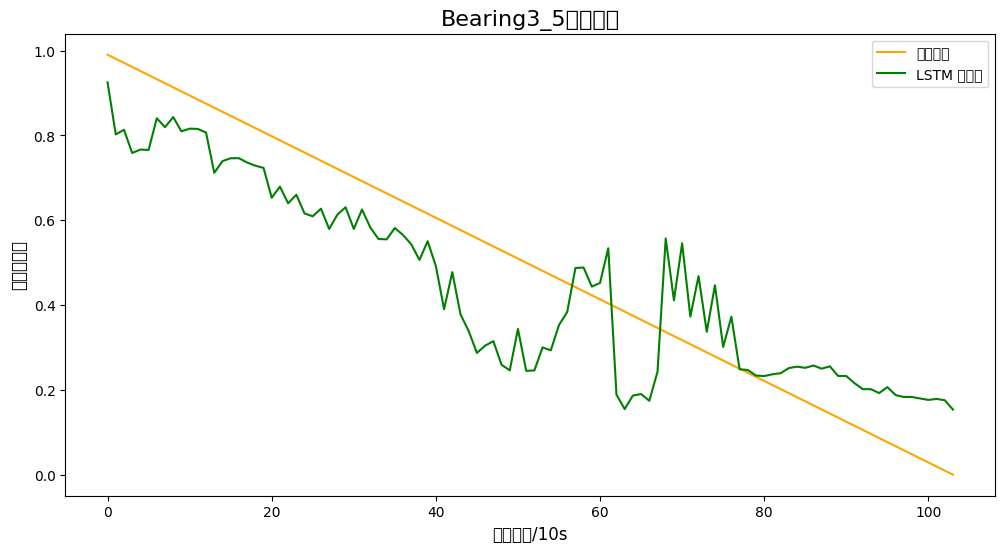

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rc("font", family='Microsoft YaHei')

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_origin_data, label='真实寿命',color='orange')  # 真实值
plt.plot(test_pre_data, label='LSTM 预测值',color='green')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置

plt.xlabel('运行周期/10s', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title(TEST_xj[0]+'预测结果', fontsize=16)
plt.legend()
plt.show()

dump(test_origin_data, '../画图对比/bilstm_origin') 
dump(test_pre_data, '../画图对比/bilstm_pre') 
import pandas as pd

# 将真实值和预测值保存为csv，真实值在第一列，预测值在第二列
result_df = pd.DataFrame(np.column_stack([test_origin_data, test_pre_data]))
result_df.to_csv(TEST_xj[0]+'_bilstm_result.csv', index=False, header=False, encoding='utf-8')
# 把当前使用的超参数也保存下来，命名为 TEST_xj[0]+'_bilstm_result.json'

import json

# 假设你的超参数字典变量名为 config，如果不是请替换为实际使用的变量名
# 为了避免出错，可通过读取你实际用到的配置文件
with open('../../config/bilstm_config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

with open(TEST_xj[0]+'_bilstm_result.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)
